In [1]:
%matplotlib inline

import pandas as pd
import os
import sys
import glob
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import math
from scipy import sparse
import random

import scanpy as sc
import scvelo as scv
import cellrank as cr

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



In [2]:

fpath = '/home/ngr4/scratch60/scnd/data/processed/'
adata = sc.read(os.path.join(fpath, 'adata_and_loom_2110514.h5ad'))


In [3]:
adata = adata[(adata.obs['ctype']=='Astrocyte') & (adata.obs['genotype']=='WT'), :]


In [4]:
adata

View of AnnData object with n_obs × n_vars = 4078 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# standard Cellrank recipe

In [5]:
# standard recipe for pancreas; REF: 
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=20, n_neighbors=30)
scv.pp.moments(adata, n_pcs=20, n_neighbors=30)

computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:13)


Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/20 cores)


  0%|          | 0/1212 [00:00<?, ?gene/s]

    finished (0:08:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:697: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:700: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [7]:
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [11]:
# recalculate phate and umap
sc.tl.umap(adata)
sc.external.tl.phate(adata, gamma=0)

computing UMAP
    finished (0:00:12)
computing PHATE


Calculating PHATE...
  Running PHATE on 4078 observations and 26374 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.49 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.71 seconds.
    Calculating affinities...
    Calculated affinities in 1.03 seconds.
  Calculated graph and diffusion operator in 7.27 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.09 seconds.
    Calculating KMeans...
    Calculated KMeans in 16.40 seconds.
  Calculated landmark operator in 18.82 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 1.79 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.64 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.99 seconds.
Calculated PHATE in 33.52 seconds.


    finished (0:00:33)


In [17]:
cmap_wt = {v:sns.cubehelix_palette(5, start=0.5, rot=-0.75)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}
cmap_mut = {v:sns.cubehelix_palette(5)[i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


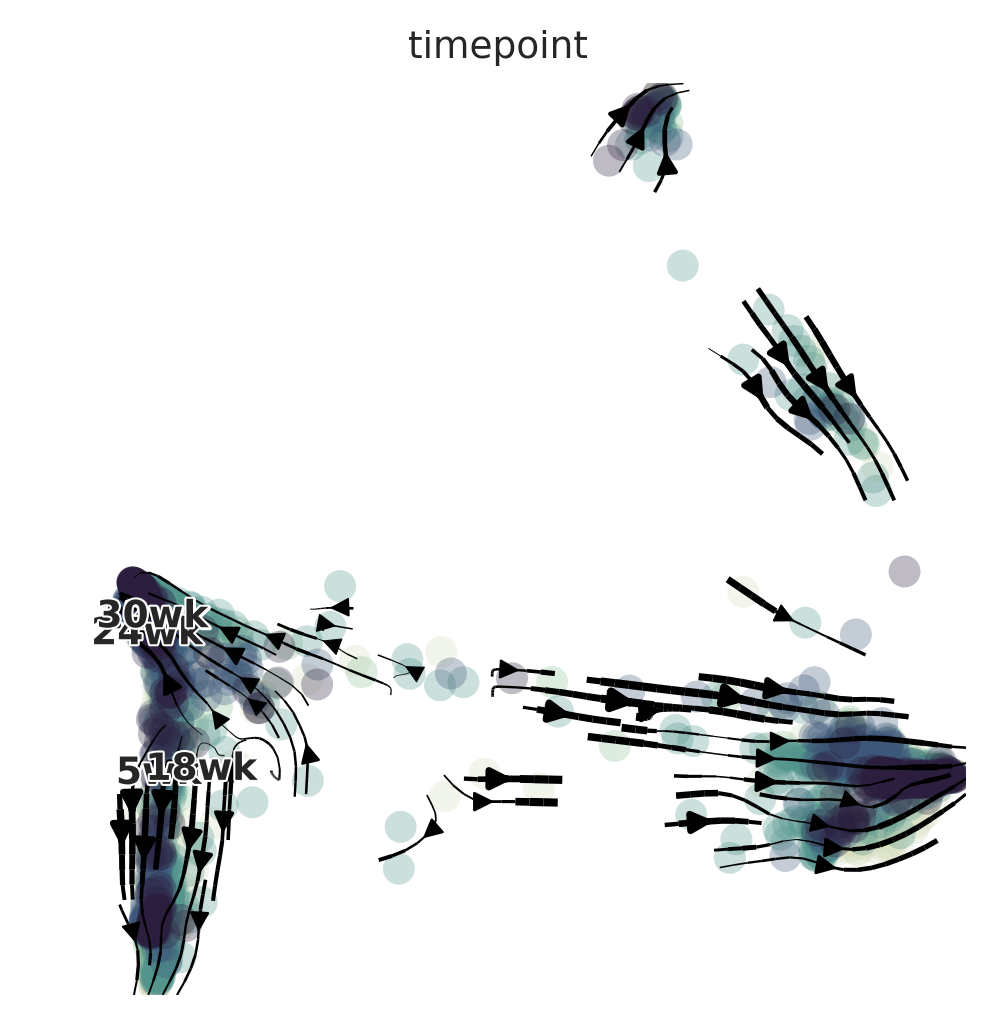

In [16]:
scv.pl.velocity_embedding_stream(adata, basis='phate', color=['timepoint',], palette=cmap_wt)


In [21]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:00)


In [22]:
cr.tl.terminal_states(adata, clusters='leiden')

  0%|          | 0/4078 [00:00<?, ?cell/s]

  0%|          | 0/4078 [00:00<?, ?cell/s]

In [ ]:
cr.tl.terminal_states(adata, clusters='leiden', estimator=cr.tl.estimators.CFLARE)


/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


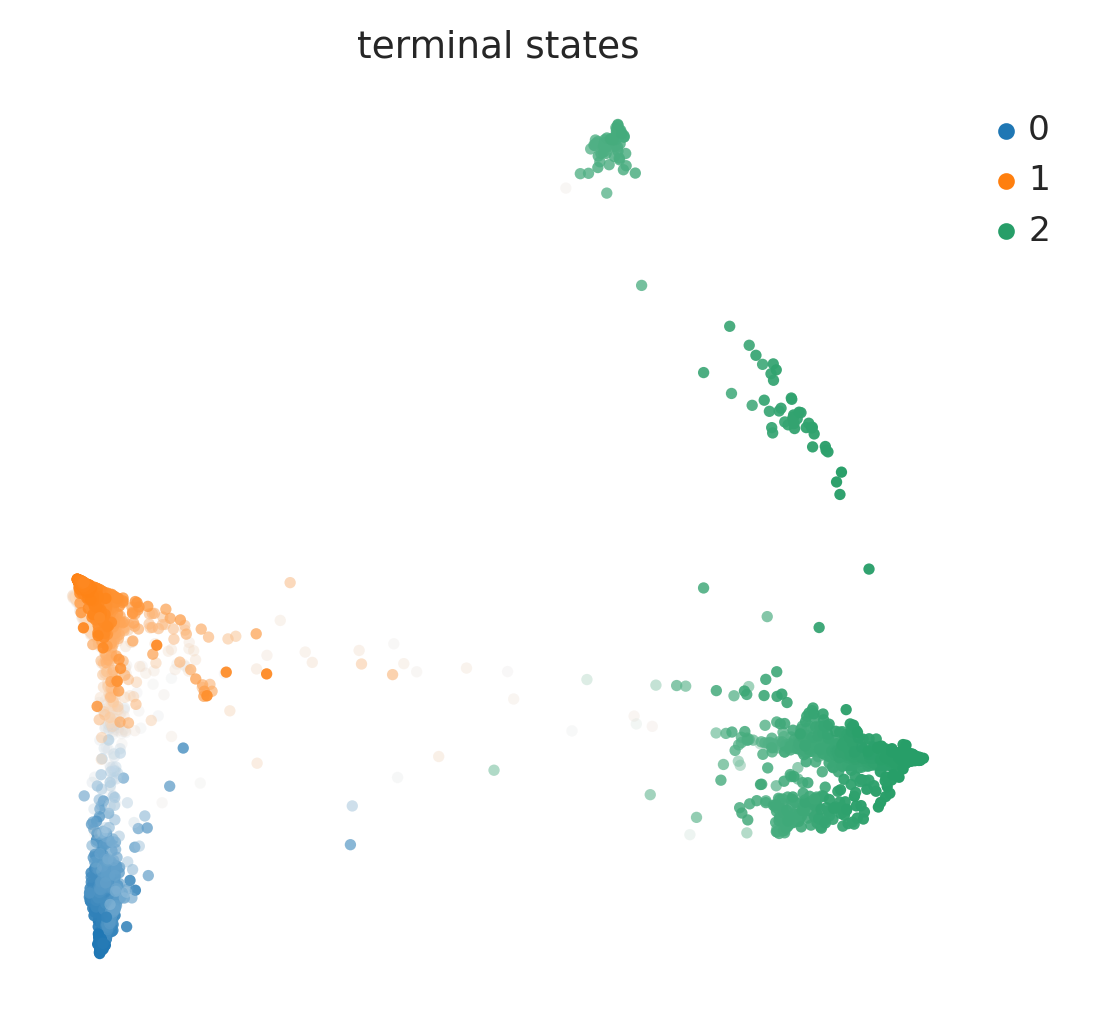

In [23]:
cr.pl.terminal_states(adata, basis='phate')


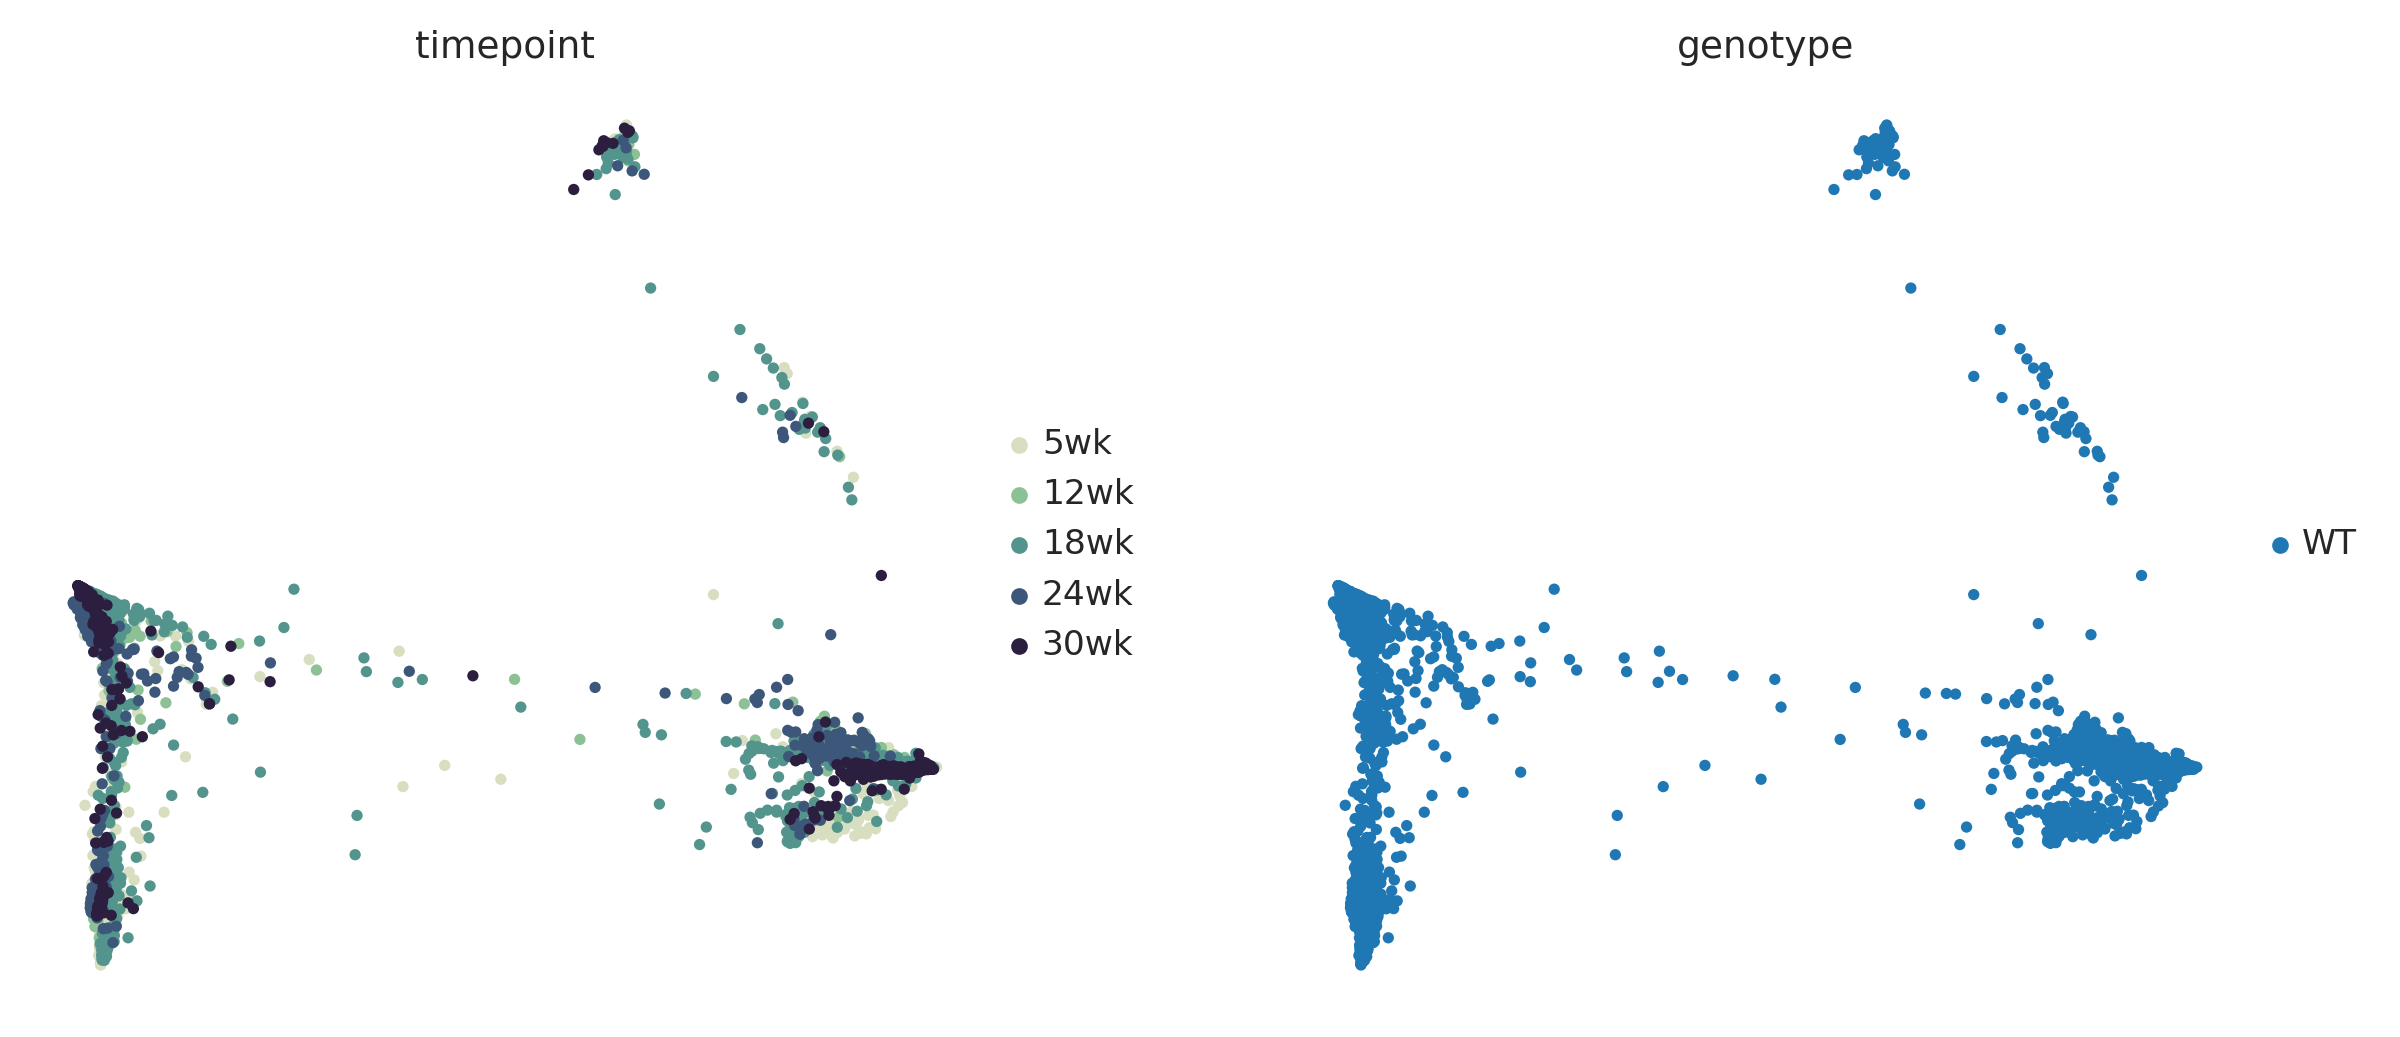

In [24]:
sc.external.pl.phate(adata, color=['timepoint', 'genotype'])

In [25]:
cr.tl.initial_states(adata, cluster_key='leiden')


  0%|          | 0/4078 [00:00<?, ?cell/s]

  0%|          | 0/4078 [00:00<?, ?cell/s]

/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


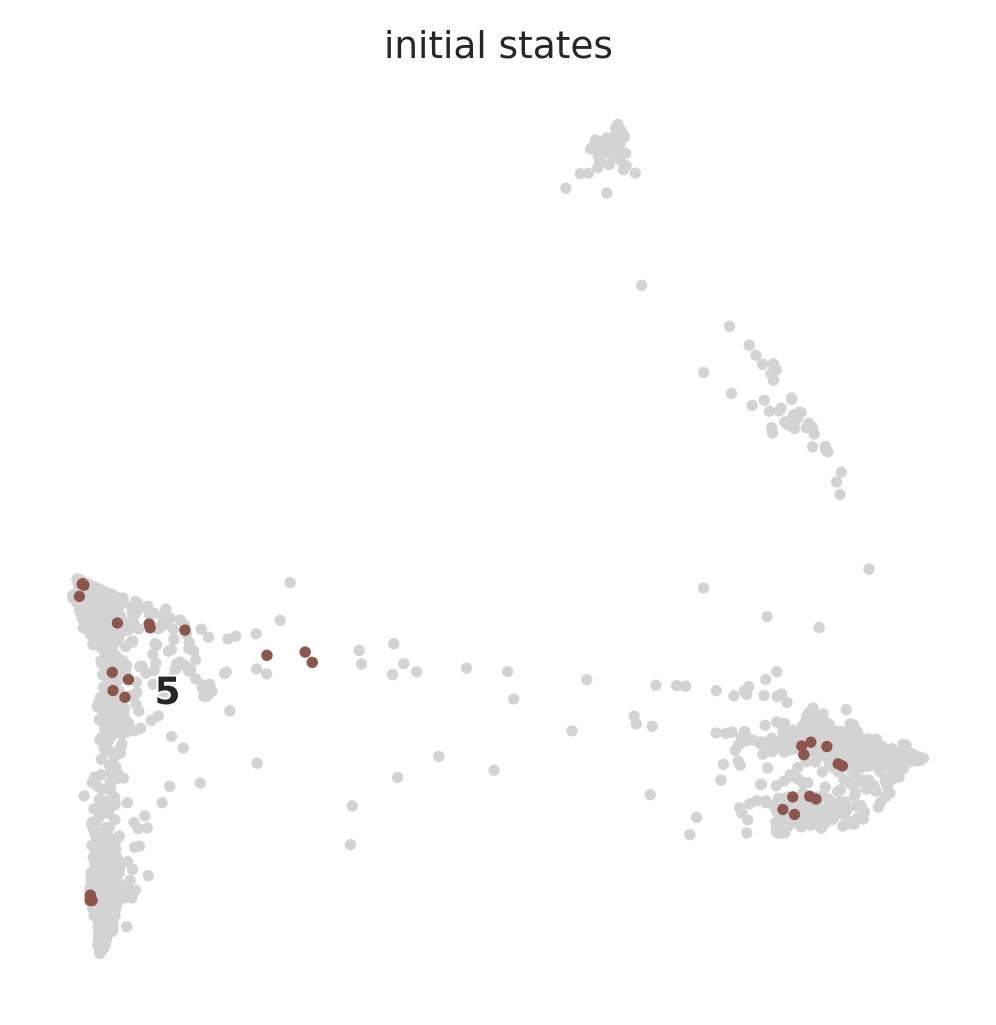

In [26]:
cr.pl.initial_states(adata, discrete=True, basis='phate')


  0%|          | 0/90 [00:00<?, ?/s]

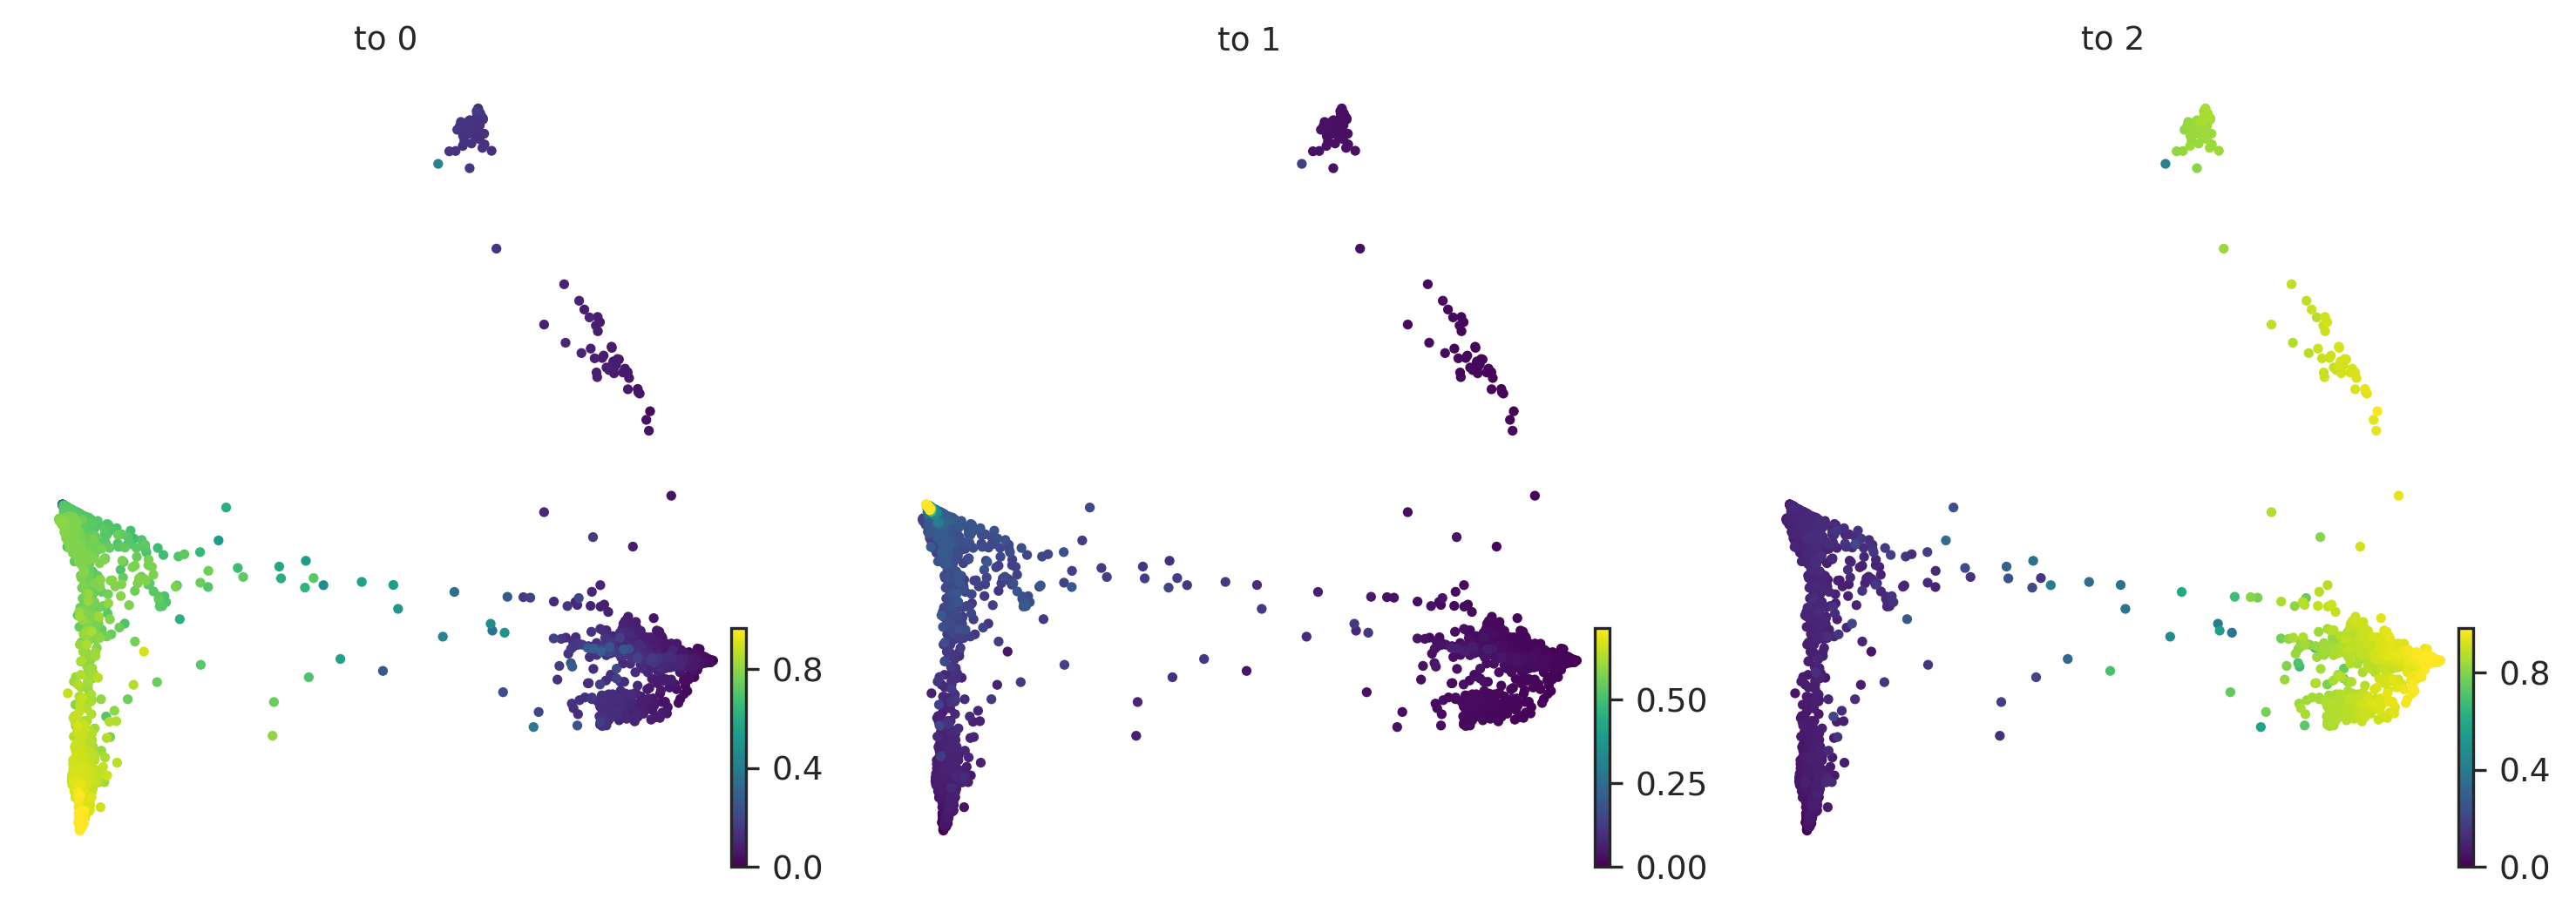

In [27]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False, basis='phate')

/gpfs/ycga/project/dijk/ngr4/conda_envs/monocle3/lib/python3.8/site-packages/scvelo/plotting/utils.py:115: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = pl.figure(None, figsize, dpi=dpi).gca(projection=projection)


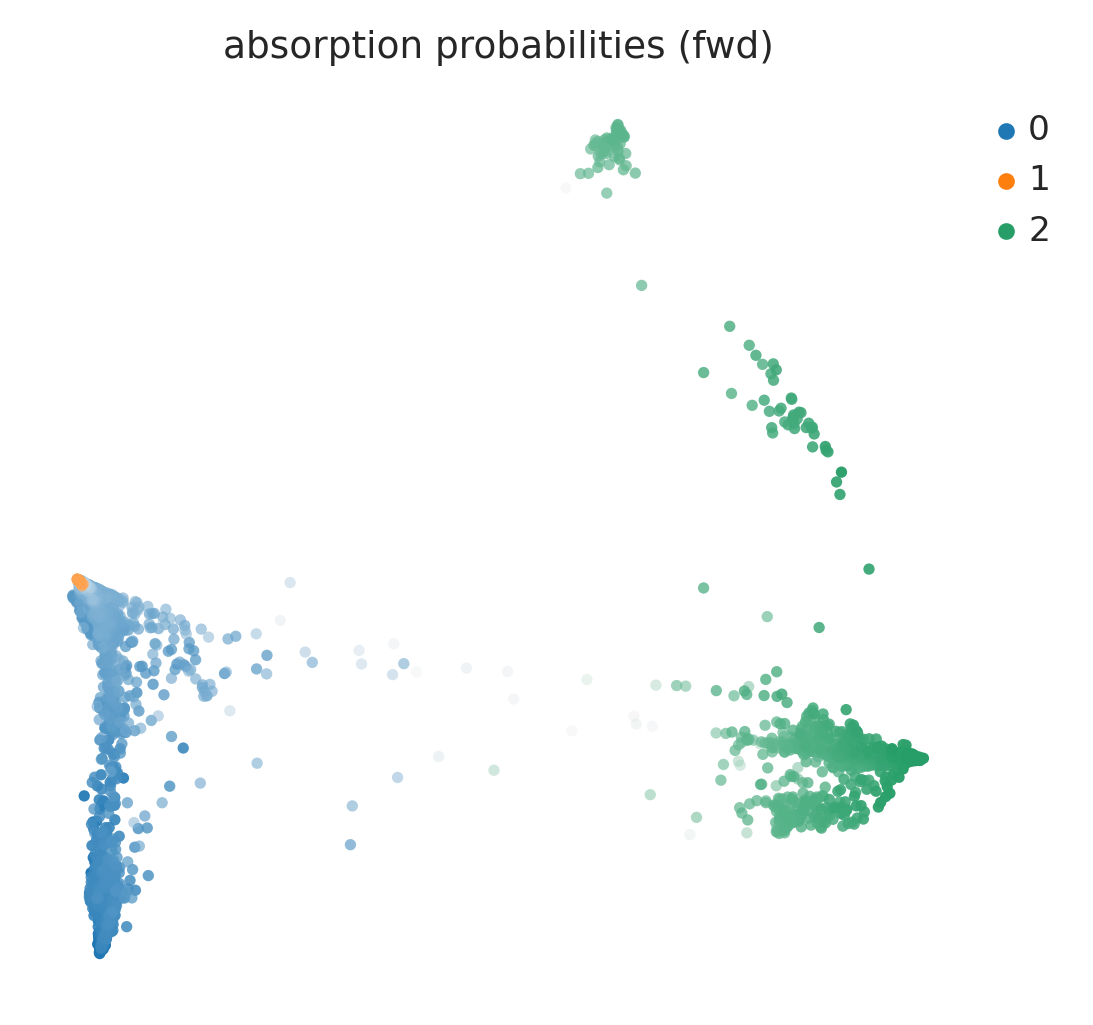

In [28]:
cr.pl.lineages(adata, same_plot=True, basis='phate')

In [29]:
# compute latent time
scv.tl.recover_latent_time(adata, root_key='initial_states_probs', end_key='terminal_states_probs')

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:02) --> added 
    'latent_time', shared time (adata.obs)


In [30]:
scv.tl.paga(adata, groups='leiden', root_key='initial_states_probs', end_key='terminal_states_probs',
            use_time_prior='velocity_pseudotime')

running PAGA using priors: ['velocity_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [31]:
import phate
data_phate1d = phate.PHATE(gamma=0, n_components=1).fit_transform(adata.X)

Calculating PHATE...
  Running PHATE on 4078 observations and 26374 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.71 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.72 seconds.
    Calculating affinities...
    Calculated affinities in 0.30 seconds.
  Calculated graph and diffusion operator in 7.74 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.31 seconds.
    Calculating KMeans...
    Calculated KMeans in 13.25 seconds.
  Calculated landmark operator in 14.73 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 1.83 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.64 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.05 seconds.
Calculated PHATE in 32.00 seconds.


In [32]:
rand_hgt = np.random.uniform(size=(data_phate1d.shape[0],))

Text(0.5, 1.0, 'Cellrank pseudotime')

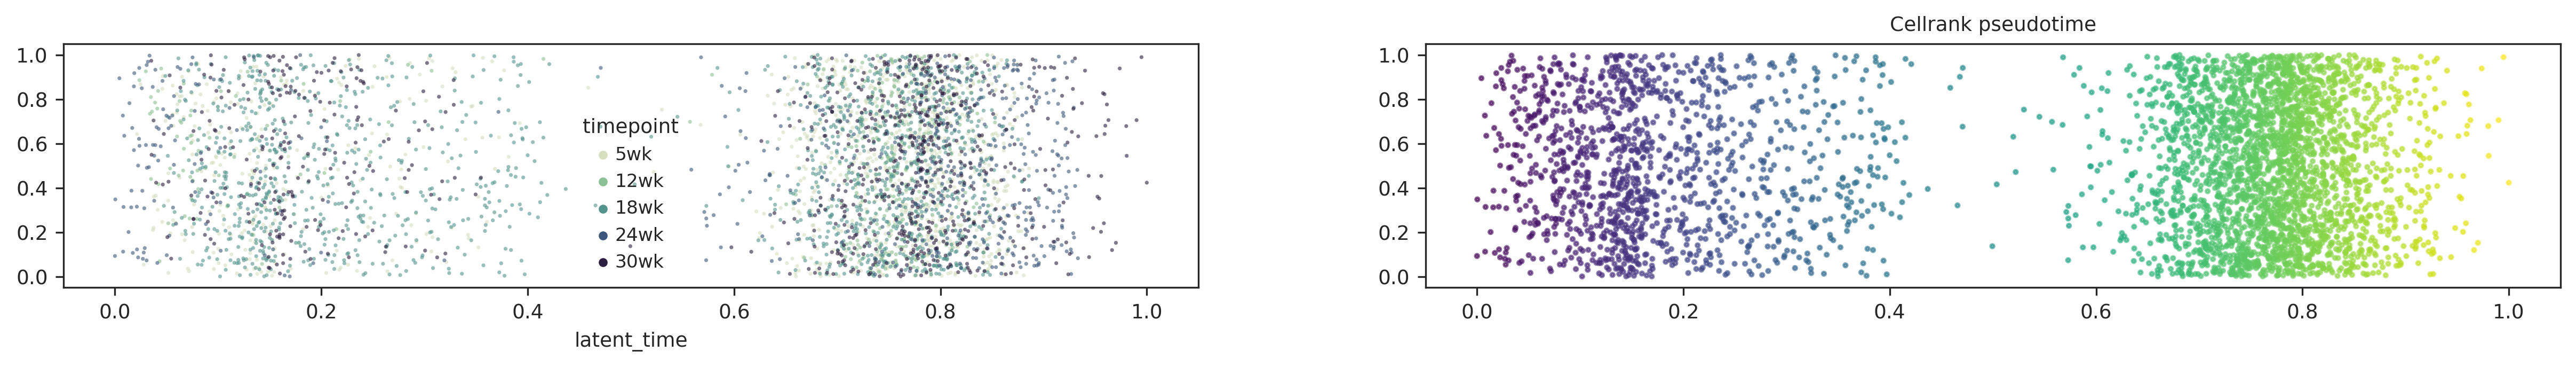

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 2))
sns.scatterplot(x=adata.obs['latent_time'], y=rand_hgt, hue=adata.obs['timepoint'], ax=ax[0], linewidth=0., alpha=0.6, s=3, palette=cmap_wt)
ax[1].scatter(adata.obs['latent_time'], rand_hgt, c=adata.obs['latent_time'].to_numpy(), cmap='viridis', s=3, alpha=0.6)
ax[1].set_title('Cellrank pseudotime')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99536264 0.98665553 0.9851587  0.97871685 0.9642767
     0.9633852  0.94649196 0.9433442  0.9407743  0.9398882  0.9341175
     0.9296344  0.9258474  0.9211793 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


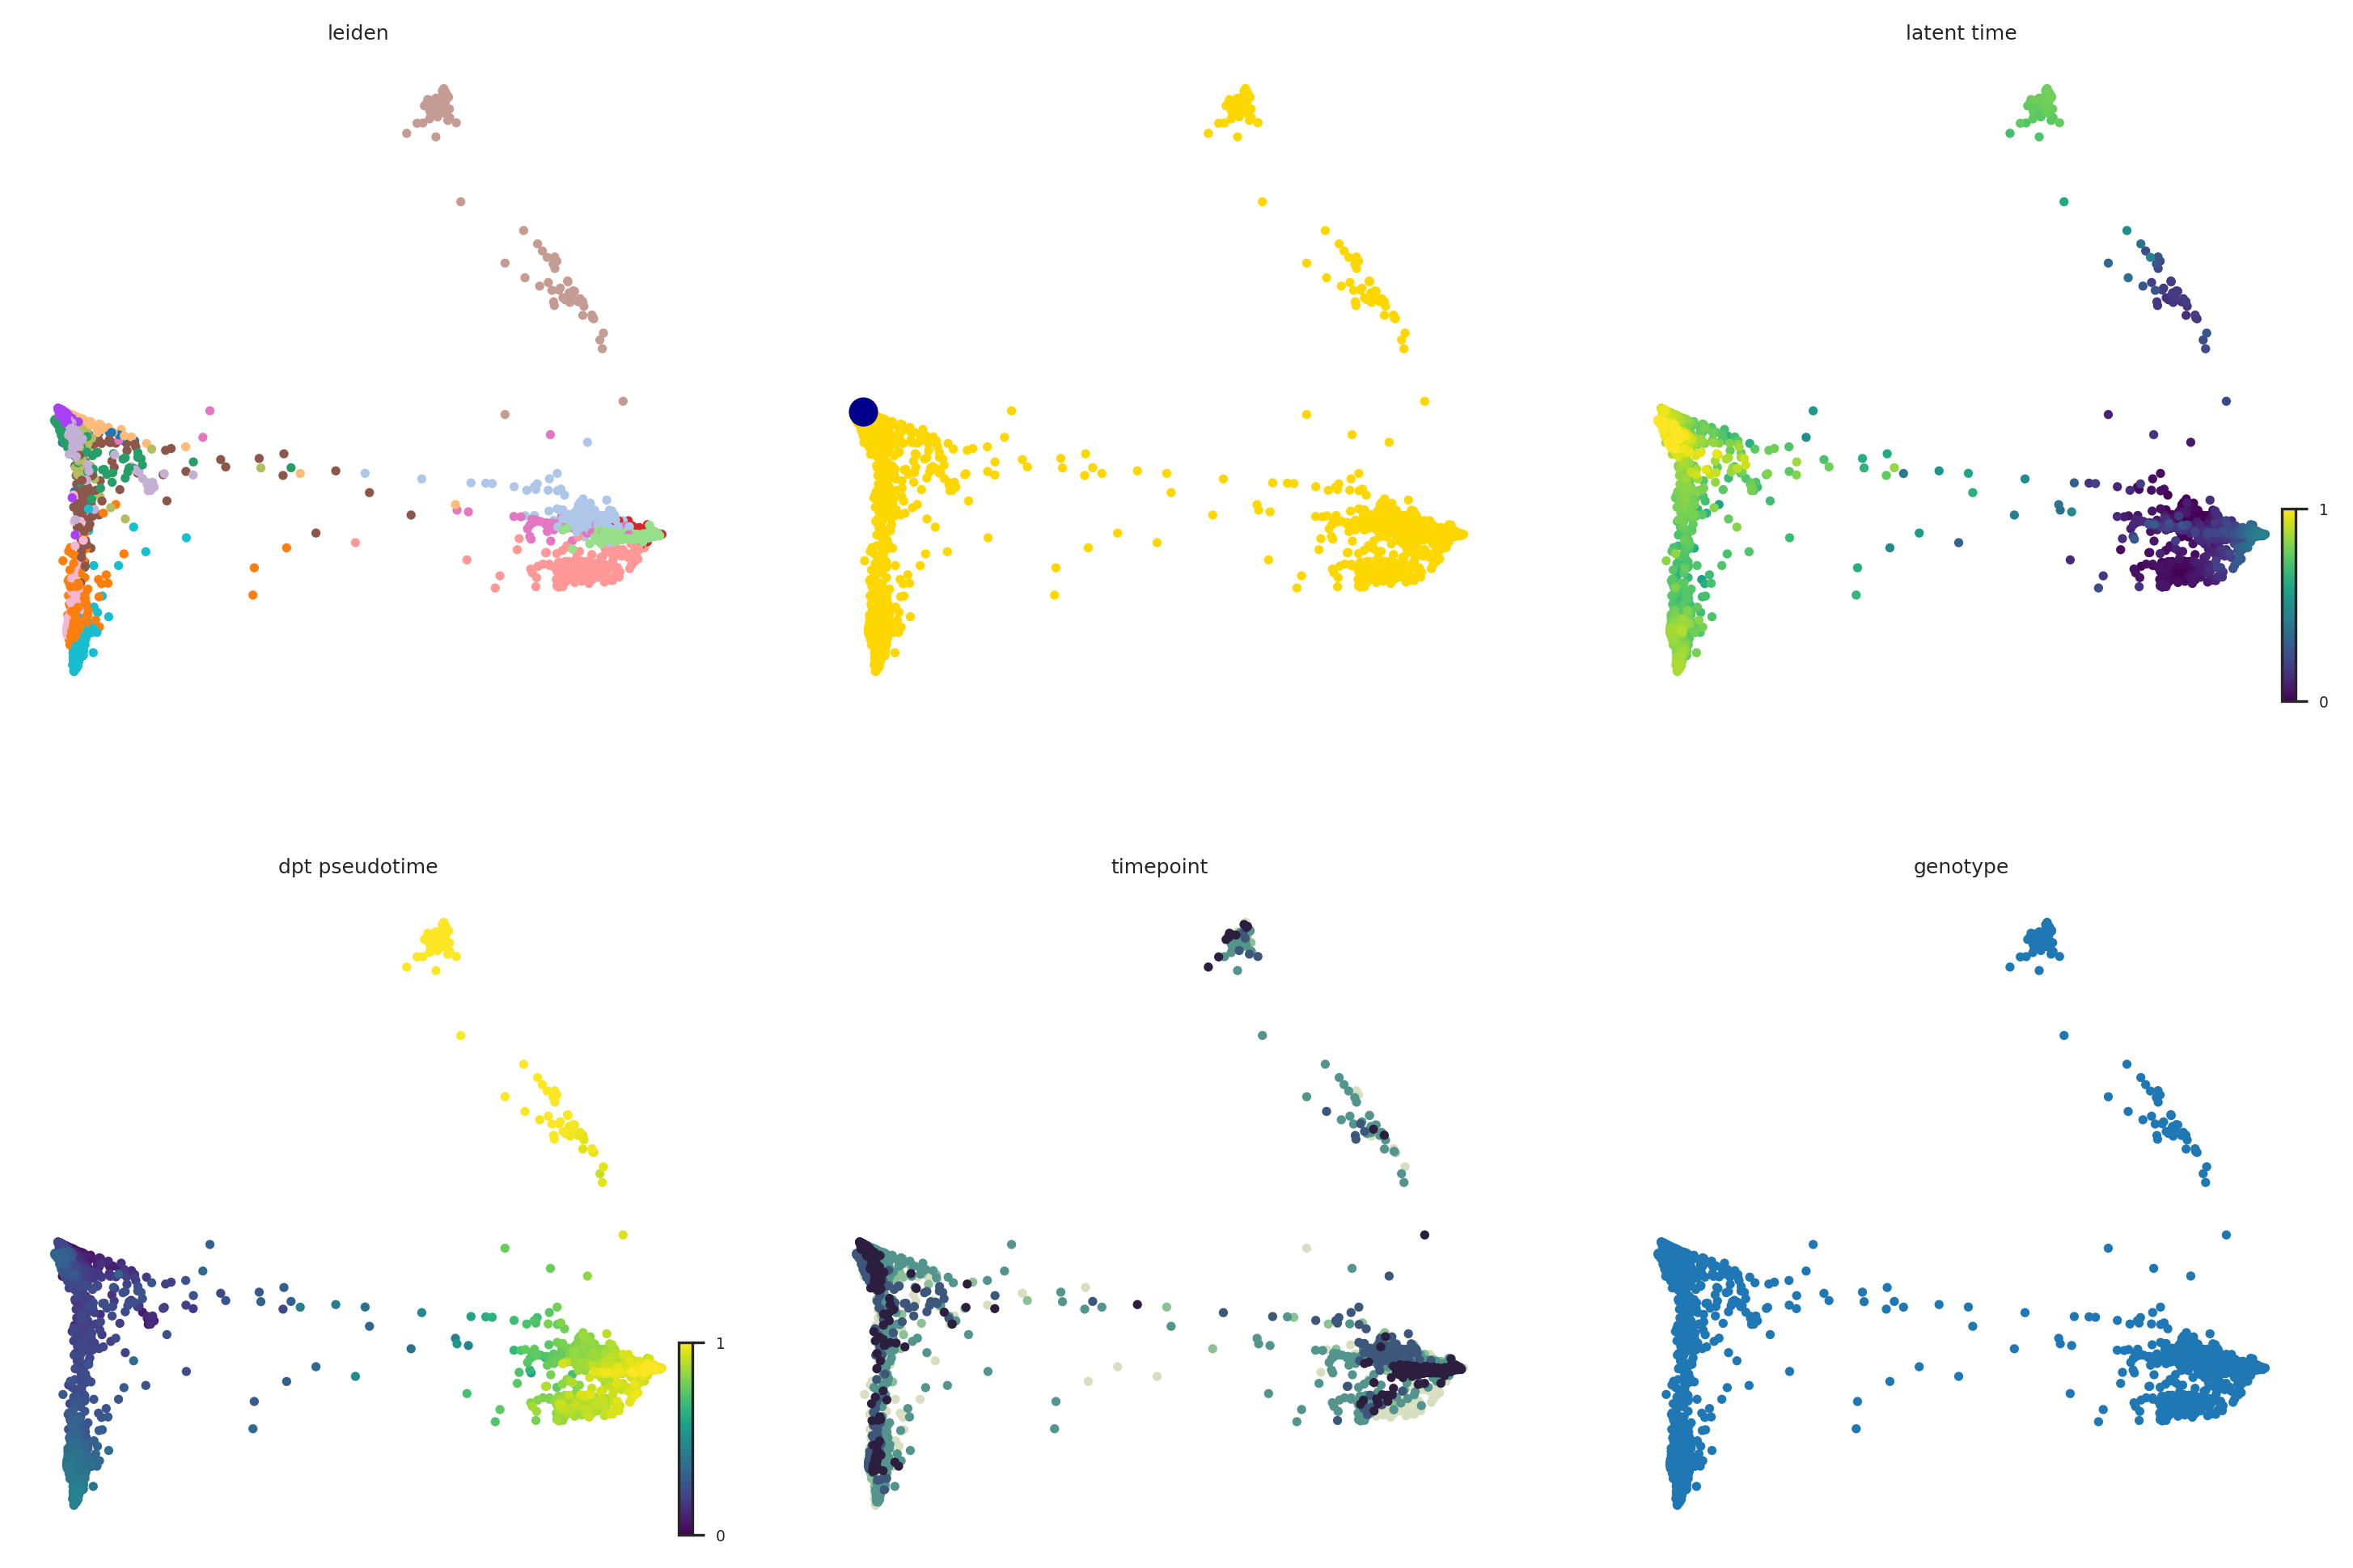

In [35]:
root_idx = np.random.choice(np.where(adata.obs['initial_states']  == '5' )[0])
adata.uns['iroot'] = root_idx
sc.tl.dpt(adata)

scv.pl.scatter(adata, color=['leiden', root_idx, 'latent_time', 'dpt_pseudotime', 'timepoint', 'genotype'],
               fontsize=6, basis='phate', ncols=3,  
               cmap='viridis', perc=[2, 98], colorbar=True, rescale_color=[0, 1])

In [99]:
adata.obs

,batch,genotype,timepoint,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,...,velocity_self_transition,leiden,terminal_states,terminal_states_probs,initial_states,initial_states_probs,clusters_gradients,velocity_pseudotime,latent_time,dpt_pseudotime
AAACCCACAGAGGAAA,7202,WT,5wk,2132,7.665285,4031.0,8.302018,25.378318,31.729099,40.287770,...,0.171722,1,NaN,0.015668,NaN,0.001027,1,0.808822,0.800734,0.100824
AAACGAATCGTGCTCT,7202,WT,5wk,2117,7.658228,4047.0,8.305978,24.141339,30.590561,39.362491,...,0.245354,0,NaN,0.028363,NaN,0.001651,1,0.843641,0.759585,0.126681
AAACGAATCGTGTCAA,7202,WT,5wk,2034,7.618251,3522.0,8.167068,21.862578,27.938671,36.910846,...,0.179791,8,NaN,0.002385,NaN,0.007468,1,0.825374,0.764099,0.072779
AAAGAACCAGTGACCC,7202,WT,5wk,2385,7.777374,5346.0,8.584291,29.517396,36.700337,45.155256,...,0.215270,1,NaN,0.043251,NaN,0.000372,1,0.814439,0.852742,0.129180
AAAGGATAGGGCAGTT,7202,WT,5wk,2437,7.798933,4615.0,8.437284,22.405200,28.602384,37.248104,...,0.013836,0,NaN,0.005123,NaN,0.003511,1,0.835244,0.698296,0.115287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCATCCCGTGTT,58242,SCA1,30wk,1871,7.534763,3112.0,8.043343,23.971722,30.012853,38.367609,...,0.084038,20,NaN,0.000718,NaN,0.001568,1,0.977327,0.679236,0.145004
TTTACGTGTCCTACAA-1,58242,SCA1,30wk,1991,7.596894,3599.0,8.188689,24.006669,30.425118,39.538761,...,0.155953,20,NaN,0.001204,NaN,0.000374,1,0.950697,0.666957,0.147171
TTTACTGCAGTCTCTC,58242,SCA1,30wk,3424,8.138857,6890.0,8.837972,17.474601,22.902758,30.711176,...,0.150448,15,NaN,0.018905,NaN,0.002258,0,0.016664,0.129440,0.502587
TTTGGTTTCCACTAGA,58242,SCA1,30wk,1514,7.323171,2535.0,7.838343,24.418146,31.597633,41.775148,...,0.164438,7,NaN,0.001601,NaN,0.000290,1,0.947889,0.741176,0.176403
